In [48]:
import pandas as pd
import torch

#grab data from working directory
main_data = pd.read_csv('data/main.csv',sep=' ')
training_data = pd.read_csv('data/training.csv',sep=' ')
validation_data = pd.read_csv('data/validation.csv',sep=' ')
# training_data = training_data.rename(columns={training_data.columns[0]: 'problem_ids', training_data.columns[2]: 'tags', training_data.columns[3]: 'statement'})
# validation_data = validation_data.rename(columns={validation_data.columns[0]: 'problem_ids', validation_data.columns[2]: 'tags', validation_data.columns[3]: 'statement'})
# main_data = main_data.rename(columns={main_data.columns[0]: 'problem_ids', main_data.columns[2]: 'tags', main_data.columns[3]: 'statement'})
print(main_data.head())

   index                  name                                    tags  \
0  1873F           Money Trees  binary search,greedy,math,two pointers   
1  1873E  Building an Aquarium                  binary search,sortings   
2  1873D             1D Eraser      greedy,implementation,two pointers   
3  1873C       Target Practice                     implementation,math   
4  1873B              Good Kid                 brute force,greedy,math   

                                           statement  rating  
0  Luca is in front of a row of n trees. The i-th...    1300  
1  You love fish, that\'s why you have decided to...    1100  
2  You are given a strip of paper s that is n cel...     800  
3  A 10\xc3\x9710 target is made out of five "rin...     800  
4  Slavic is preparing a present for a friend\'s ...     800  


In [49]:
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [50]:
# prompt: write a function that filters out all rows that have empty statement or tag columns, empty as a string or empty in the df sense

def filter_empty_rows(df):
  """Filters out rows with empty 'statement' or 'tags' columns.

  Args:
    df: A pandas DataFrame.

  Returns:
    A new DataFrame with rows containing empty 'statement' or 'tags' removed.
  """
  df = df.dropna(subset=['statement', 'tags'])
  df = df[df['statement'].str.len() > 0]
  df = df[df['tags'].str.len() > 0]

  #also drop any row that has the tag *special problem
  df = df[~df['tags'].str.contains('*special problem',regex=False)]

  #also drop any row that has the tag NA
  df = df[~df['tags'].str.contains('NA',regex=False)]

  return df

training_data = filter_empty_rows(training_data)
validation_data = filter_empty_rows(validation_data)
main_data = filter_empty_rows(main_data)

In [51]:

n = 5  # Hyperparameter for the number of most frequent tags

all_tags = []
for tags in main_data['tags']:
    all_tags.extend(tags.split(','))

from collections import Counter

tag_counts = Counter(all_tags)
most_frequent_tags = set([tag for tag, count in tag_counts.most_common(n)])
index_to_tag = {i: tag for i, tag in enumerate(most_frequent_tags)}
tag_to_index = {tag: i for i, tag in index_to_tag.items()}
print(f"The {n} most frequent tags are: {most_frequent_tags}")

# prompt: what percent of problems use a tag found in the n most common ?

problems_with_top_n_tags = 0
total_problems = len(main_data)

for tags in main_data['tags']:
  if isinstance(tags, str):
    for tag in tags.split(','):
      if tag in most_frequent_tags:
        problems_with_top_n_tags += 1
        break  # Only count the problem once if it has at least one top-n tag

percentage = (problems_with_top_n_tags / total_problems) * 100
print(f"Percentage of problems with at least one of the top {n} tags: {percentage:.2f}%")

The 5 most frequent tags are: {'math', 'constructive algorithms', 'implementation', 'greedy', 'dp'}
Percentage of problems with at least one of the top 5 tags: 83.74%


In [52]:
# prompt: remove any tags that are not in the top n

import pandas as pd
import torch
from collections import Counter

# ... (Your existing code) ...

def filter_tags(tags_str, most_frequent_tags):
  """Filters tags in a string to only include the top n tags.

  Args:
    tags_str: A string of comma-separated tags.
    most_frequent_tags: A set of the top n most frequent tags.

  Returns:
    A new string of comma-separated tags, containing only the top n tags.
  """
  tags = tags_str.split(',')
  filtered_tags = [tag for tag in tags if tag in most_frequent_tags]
  return ','.join(filtered_tags)


main_data['tags'] = main_data['tags'].apply(lambda tags: filter_tags(tags, most_frequent_tags))
training_data['tags'] = training_data['tags'].apply(lambda tags: filter_tags(tags, most_frequent_tags))
validation_data['tags'] = validation_data['tags'].apply(lambda tags: filter_tags(tags, most_frequent_tags))

# ... (Rest of your code) ...

Subset transform below


In [53]:

def transform_training_data(df):
    transformed_data = []
    for index, row in df.iterrows():
        tags = row['tags'].split(',')
        tags = [tag for tag in tags if tag in most_frequent_tags]
        num_tags = len(tags)
        for i in range(2**num_tags):
            subset_tags = []
            for j in range(num_tags):
                if (i >> j) & 1:
                    subset_tags.append(tags[j])
            new_row = row.copy()
            new_row['tags'] = ','.join(subset_tags)
            transformed_data.append(new_row)
    return pd.DataFrame(transformed_data)
# comment out for now
training_data = transform_training_data(training_data)
print(len(training_data))

6480


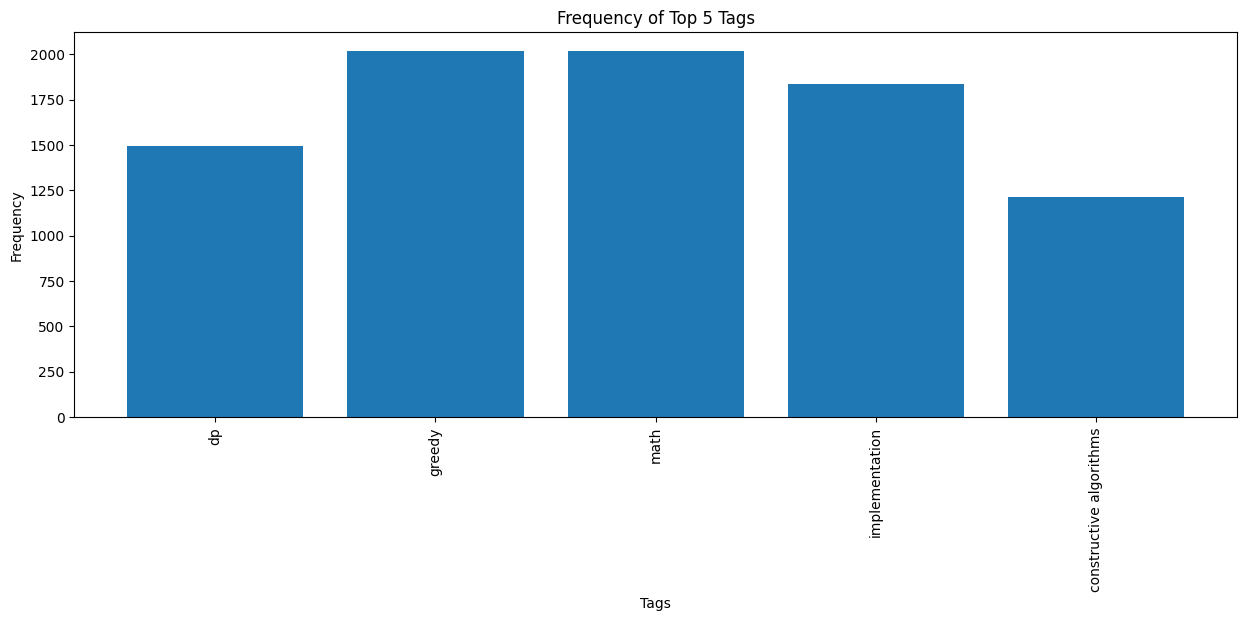

Text(0.5, 1.0, 'Frequency of Number of Tags')

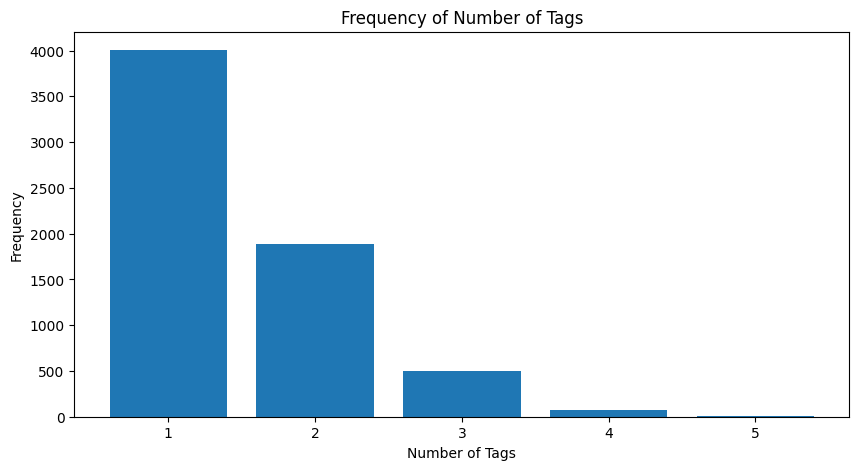

In [54]:

import matplotlib.pyplot as plt
from collections import Counter

# Assuming 'main_data' and 'most_frequent_tags' are defined as in your previous code


print(len(training_data))

# Bar graph for tag frequency
tag_frequencies = Counter([tag for tags in training_data['tags'].dropna() for tag in tags.split(',') if tag in most_frequent_tags])

plt.figure(figsize=(15, 5))
plt.bar(tag_frequencies.keys(), tag_frequencies.values())
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title(f'Frequency of Top {n} Tags')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


#bar graph for how many problems have k different tags in the top n
tag_counts = {}
for tags in training_data['tags'].dropna():
  if isinstance(tags, str):
    tag_count = len(tags.split(','))
    if tag_count in tag_counts:
      tag_counts[tag_count] += 1
    else:
      tag_counts[tag_count] = 1

plt.figure(figsize=(10, 5))
plt.bar(tag_counts.keys(), tag_counts.values())
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.title(f'Frequency of Number of Tags')

In [55]:
from transformers import BertTokenizer
def problem_tags_to_vector(tags_string, most_frequent_tags, n):
  """
  Converts a string of problem tags to a PyTorch vector of length n.

  Args:
    tags_string: A string of problem tags separated by commas.
    most_frequent_tags: A set of the n most frequent problem tags.
    n: The length of the vector.

  Returns:
    A PyTorch vector of floats, where a[i] is 1 if the ith most frequent
    problem tag is present in the tags_string, and 0 otherwise.
  """
  if not isinstance(tags_string, str):
    return torch.zeros(n)
  tags = set(tags_string.split(','))
  vector = [1.0 if tag in tags else 0.0 for tag in most_frequent_tags]
  return torch.tensor(vector, dtype=torch.float32)

MAXLEN = 512
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_text(text):
  return tokenizer(text, padding='max_length', truncation=True, max_length=MAXLEN)

In [56]:
from transformers import BertModel
from torch.utils.data import Dataset
import torch.nn.init as init
import torch.nn as nn

class TagModel(nn.Module):
    def __init__(self):
        super(TagModel, self).__init__()
        self.bert = BertModel.from_pretrained('prajjwal1/bert-small')
        self.dropout = nn.Dropout(0.4)  # Experiment with dropout rate (e.g., 0.1-0.5)
        self.tag_classifier = nn.Sequential(
            nn.Linear(512, n),  # Your original linear layer
            nn.LayerNorm(n)   # Layer Normalization layer
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)  # Apply dropout
        tag_pred = self.tag_classifier(pooled_output)
        return tag_pred

def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, tags, device):
        self.input_ids = input_ids.to(device)
        self.attention_mask = attention_mask.to(device)
        self.tags = tags.to(device)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.tags[idx]

In [57]:
from torch.utils.data import DataLoader, TensorDataset

texts = training_data['statement'].tolist()
encodings = tokenizer(texts, truncation=True, padding=True, max_length=MAXLEN)

tags = training_data['tags'].tolist()
tags = [problem_tags_to_vector(tag, most_frequent_tags, n) for tag in tags]

input_ids = torch.tensor(encodings['input_ids'])
attention_mask = torch.tensor(encodings['attention_mask'])

tags = torch.stack(tags)

#validation stuff
val_texts = validation_data['statement'].tolist()
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=MAXLEN)

val_tags = validation_data['tags'].tolist()
val_tags = [problem_tags_to_vector(tag, most_frequent_tags, n) for tag in val_tags]

val_input_ids = torch.tensor(val_encodings['input_ids'])
val_attention_mask = torch.tensor(val_encodings['attention_mask'])

val_tags = torch.stack(val_tags)

bsz = 32
val_dataset = CustomDataset(val_input_ids, val_attention_mask, val_tags, device)
val_loader = DataLoader(val_dataset, batch_size=bsz, shuffle=True)
dataset = CustomDataset(input_ids, attention_mask, tags, device)
loader = DataLoader(dataset, batch_size=bsz, shuffle=True)

In [58]:
# prompt: write a function that runs the model on the validation data set, and determines its accuracy on each specific tag. Returns a vector length n with the % accuracy for each tag. The model uses a threshold of 0.5 for classification. remember to apply sigmoid to map the output layer to [0,1]

def evaluate_tag_accuracy(model, val_loader, device, n):
  """
  Evaluates the model's accuracy on the validation dataset for each tag.

  Args:
    model: The trained model.
    val_loader: The DataLoader for the validation dataset.
    device: The device to run the model on (e.g., 'cuda' or 'cpu').
    n: The number of tags.

  Returns:
    A list of floats, representing the accuracy for each tag.
  """

  model.eval()  # Set the model to evaluation mode
  tag_correct_counts = [0] * n
  tag_total_counts = [0] * n
  avg_loss = 0
  with torch.no_grad():
    for batch in val_loader:
      input_ids, attention_mask, true_tags = batch
      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      true_tags = true_tags.to(device)

      tag_pred = model(input_ids, attention_mask)
      loss = nn.BCEWithLogitsLoss()(tag_pred, true_tags)
      avg_loss += loss.item()
      tag_pred = torch.sigmoid(tag_pred)  # Apply sigmoid to get probabilities in [0,1]

      predicted_tags = (tag_pred > 0.5).float()

      for i in range(n):
        tag_correct_counts[i] += (predicted_tags[:, i] == true_tags[:, i]).sum().item()
        tag_total_counts[i] += true_tags.shape[0]
  avg_loss /= len(val_loader)

  tag_accuracies = []
  for i in range(n):
    if tag_total_counts[i] > 0:
      tag_accuracies.append(tag_correct_counts[i] / tag_total_counts[i] * 100)
    else:
      tag_accuracies.append(0.0)

  return (avg_loss,tag_accuracies)

In [59]:
import matplotlib.pyplot as plt
from IPython import display
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

total_losses = []
val_losses = []
val_acc = []

model = TagModel()
model.apply(init_weights)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = StepLR(optimizer, step_size = 3, gamma = 0.5) # Initialize StepLR
model.train()

EPOCHS = 35
for epoch in range(EPOCHS):
    loop = tqdm(loader, leave=True) # wrap the dataloader with tqdm
    for batch_idx, batch in enumerate(loop):
        input_ids, attention_mask, tag_labels = batch

        optimizer.zero_grad()
        tag_pred = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = nn.BCEWithLogitsLoss()(tag_pred, tag_labels)

        total_losses.append(loss.item())

        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch + 1}/{EPOCHS}]")
        loop.set_postfix(tag_loss=loss.item())

    scheduler.step() # Update learning rate at each step
    print(f"Epoch {epoch + 1} completed.")
    model.eval()
    avg_loss, tag_accuracies = evaluate_tag_accuracy(model, val_loader, device, n)
    val_losses.append(avg_loss)
    val_acc.append(tag_accuracies)
    print(f"Validation Loss: {avg_loss}")
    print(f"Tag Accuracies: {tag_accuracies}")
    model.train()


Epoch [1/5]: 100%|██████████| 203/203 [01:38<00:00,  2.07it/s, tag_loss=0.713]


Epoch 1 completed.
Validation Loss: 0.731088175015016
Tag Accuracies: [56.57142857142857, 81.57142857142857, 48.07142857142857, 39.214285714285715, 68.21428571428572]


Epoch [2/5]: 100%|██████████| 203/203 [01:40<00:00,  2.02it/s, tag_loss=0.664]


Epoch 2 completed.
Validation Loss: 0.6825558055530895
Tag Accuracies: [61.42857142857143, 81.14285714285714, 70.5, 54.785714285714285, 52.78571428571428]


Epoch [3/5]: 100%|██████████| 203/203 [01:40<00:00,  2.03it/s, tag_loss=0.64]


Epoch 3 completed.
Validation Loss: 0.659696492281827
Tag Accuracies: [66.21428571428571, 82.0, 57.92857142857143, 67.78571428571428, 54.285714285714285]


Epoch [4/5]: 100%|██████████| 203/203 [01:40<00:00,  2.03it/s, tag_loss=0.612]


Epoch 4 completed.
Validation Loss: 0.6444695700298656
Tag Accuracies: [66.78571428571428, 79.21428571428571, 65.5, 61.357142857142854, 68.07142857142857]


Epoch [5/5]: 100%|██████████| 203/203 [01:40<00:00,  2.02it/s, tag_loss=0.621]


Epoch 5 completed.
Validation Loss: 0.6451658091761849
Tag Accuracies: [70.5, 76.57142857142857, 64.35714285714286, 64.28571428571429, 67.0]


In [60]:
# prompt: save model to a file
torch.save(model.state_dict(), 'models/new_ExpLR_35.pt')

graphing things below

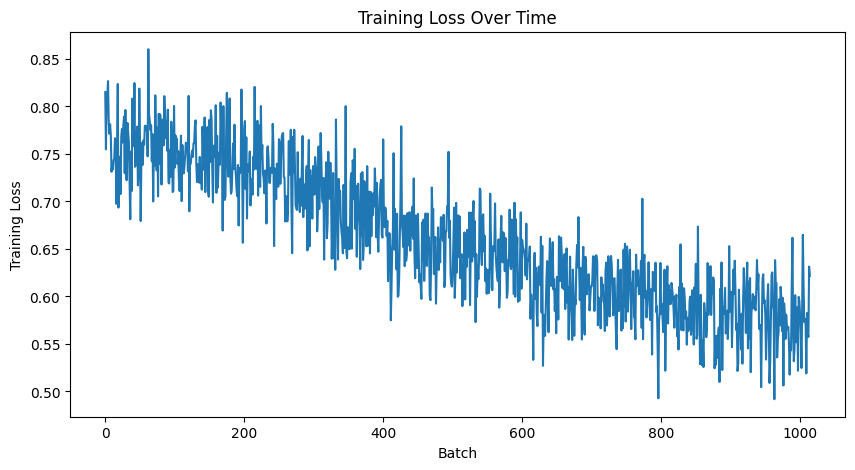

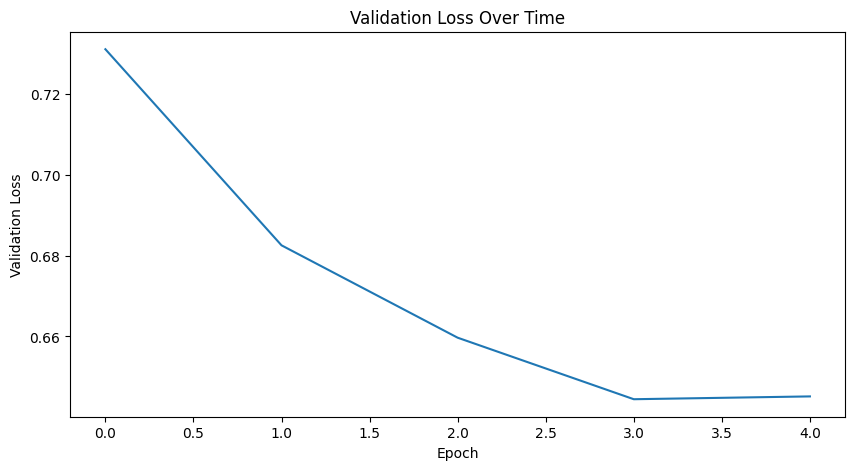

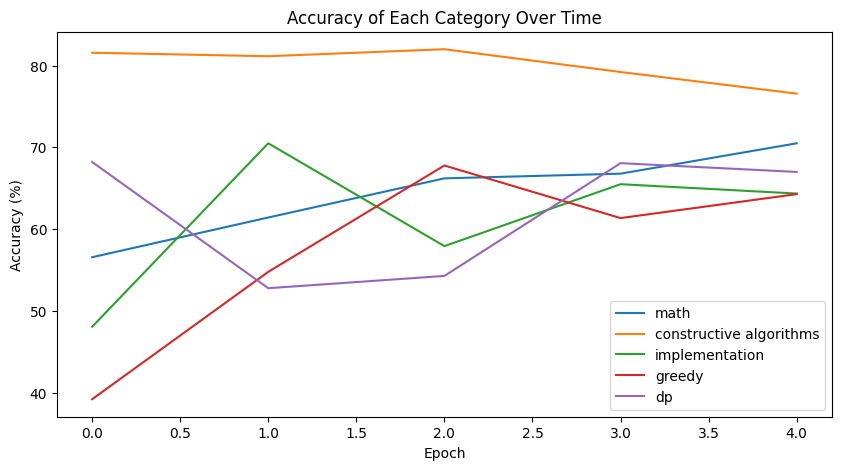

Average Accuracy for Epoch 1: 58.73%
Average Accuracy for Epoch 2: 64.13%
Average Accuracy for Epoch 3: 65.64%
Average Accuracy for Epoch 4: 68.19%
Average Accuracy for Epoch 5: 68.54%


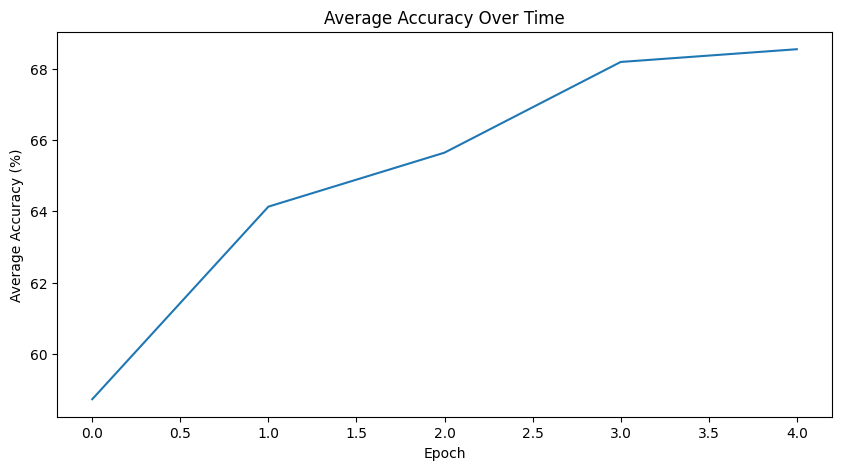

In [61]:
# prompt: make 3 charts, one the training loss over time, one the validation loss for each epoch and another with the accuracy rates of each category over each epoch label the categories by their true names found in index_to_tag

# Plot training loss over time
plt.figure(figsize=(10, 5))
plt.plot(total_losses)
plt.xlabel('Batch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Time')
plt.show()

# Plot validation loss for each epoch
plt.figure(figsize=(10, 5))
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Time')
plt.show()

# Plot accuracy rates of each category over epochs
plt.figure(figsize=(10, 5))
for i in range(n):
  accuracies = [epoch_accuracies[i] for epoch_accuracies in val_acc]
  plt.plot(accuracies, label=index_to_tag[i])

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Each Category Over Time')
plt.legend()
plt.show()
# prompt: now make a new char just for the average accuracy

# Calculate and print the average accuracy across all tags for each epoch
for epoch in range(EPOCHS):
    avg_epoch_accuracy = sum(val_acc[epoch]) / len(val_acc[epoch])
    print(f"Average Accuracy for Epoch {epoch + 1}: {avg_epoch_accuracy:.2f}%")

# Plot the average accuracy over epochs
plt.figure(figsize=(10, 5))
avg_accuracies = [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in val_acc]
plt.plot(avg_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy (%)')
plt.title('Average Accuracy Over Time')
plt.show()